In [1]:
import pyabc
from pyabc import ABCSMC
from slad import *
import sklearn.gaussian_process as skl_gp
import logging

# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

problem = PrangleLVProblem()

distances = [
    pyabc.PNormDistance(),
    pyabc.AdaptivePNormDistance(n_fit_scales=1, scale_function=pyabc.distance.root_mean_square_deviation),
    pyabc.AdaptivePNormDistance(n_fit_scales=np.inf, scale_function=pyabc.distance.root_mean_square_deviation),
    pyabc.PNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=False, normalize_labels=False)),
    pyabc.PNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=True, normalize_labels=True)),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=True, normalize_labels=True, n_fit=4), n_fit_scales=np.inf),
    pyabc.PNormDistance(sumstat=pyabc.GPPredictorSumstat(kernel=pyabc.GPKernelHandle(kernels=['RBF', 'WhiteKernel'], ard=True), n_restarts_optimizer=5)),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.GPPredictorSumstat(kernel=pyabc.GPKernelHandle(kernels=['RBF', 'WhiteKernel'], ard=True), n_restarts_optimizer=5)),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.GPPredictorSumstat(kernel=pyabc.GPKernelHandle(kernels=['RBF', 'WhiteKernel'], ard=True), n_restarts_optimizer=5, n_fit=4)),
    #pyabc.AdaptivePNormDistance(sumstat=pyabc.GPPredictorSumstat(kernel=pyabc.GPKernelHandle(kernels=['RBF', 'WhiteKernel'], ard=True), n_fit=4, joint=False)),
    #pyabc.AdaptivePNormDistance(sumstat=pyabc.GPPredictorSumstat(kernel=pyabc.GPKernelHandle(kernels=['Matern', 'WhiteKernel'], ard=True), n_fit=4)),
    pyabc.PNormDistance(sumstat=pyabc.MLPPredictorSumstat()),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.MLPPredictorSumstat(n_fit=4)),
    pyabc.PNormDistance(sumstat=pyabc.PredictorSumstat(
        predictor=pyabc.ModelSelectionPredictor(
            predictors=[pyabc.LinearPredictor(), pyabc.GPPredictor(), pyabc.MLPPredictor()]
        ),
        n_fit=1,
    )),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.PredictorSumstat(
        predictor=pyabc.ModelSelectionPredictor(
            predictors=[pyabc.LinearPredictor(), pyabc.GPPredictor(), pyabc.MLPPredictor()]
        ),
        n_fit=4,
    )),
    pyabc.distance.InfoWeightedPNormDistance(predictor=pyabc.ModelSelectionPredictor(
            predictors=[pyabc.LinearPredictor(), pyabc.GPPredictor(), pyabc.MLPPredictor()]
        ),
        n_fit_info=4,
    ),
]

labels = [
    'Euclidean',
    'Calibrated Euclidean',
    'Adaptive Euclidean',
    'Learned linear nn',
    'Learned linear tt',
    'Adaptive LL tn n_fit=4',
    'GP',
    'Adaptive GP',
    'Adaptive GP n_fit=4',
    'MLP',
    'Adaptive MLP n_fit=4',
    'MS',
    'Adaptive MS n_fit=4',
    'Adaptive Info MS n_fit=4',
]

assert len(distances) == len(labels)

In [2]:
hs = []

for distance, label in zip(distances, labels):
    print(label)
    abc = ABCSMC(problem.get_model(), problem.get_prior(), distance, population_size=100)
    abc.new(pyabc.create_sqlite_db_id(), problem.get_obs())
    h = abc.run(max_total_nr_simulations=5e3)
    hs.append(h)

INFO:Sampler:Parallelizing the sampling on 4 cores.


Euclidean


INFO:History:Start <ABCSMC id=223, start_time=2021-04-19 08:27:01.325889>
INFO:ABC:Calibration sample t=-1.
Process Process-3:
Process Process-2:
Process Process-4:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yannik/anaconda3/envs/env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yannik/anaconda3/envs/env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/yannik/anaconda3/envs/env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yannik/anaconda3/envs/env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
INFO:History:Done <ABCSMC id=223, duration=0:00:06.587298, end_time=2021-04-19 08:27:07.913187>
  File "/home/yannik/anaconda3/envs/env/lib/

KeyboardInterrupt: 

AssertionError: The number of labels does not fit

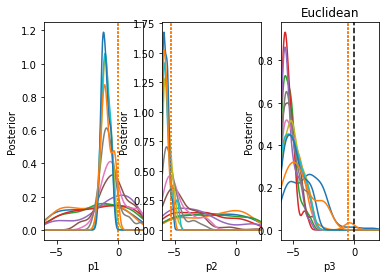

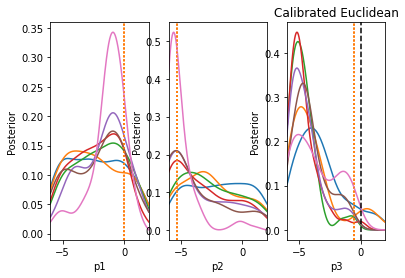

In [4]:
import matplotlib.pyplot as plt

def plot_history(history: pyabc.History, label: str):
    gt_pars = problem.get_gt_par()
    prior_bounds = problem.get_prior_bounds()
    
    fig, ax = plt.subplots(1,len(gt_pars))
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        for ix, (par, (lb, ub)) in enumerate(prior_bounds.items()):
            pyabc.visualization.plot_kde_1d(
                df, w, xmin=lb, xmax=ub, numx=300, refval=gt_pars,
                x=par, xname=par, ax=ax[ix],
                label="PDF t={}".format(t))
    ax[-1].axvline(0, color='k', linestyle='dashed', label="True value")
    #ax[-1].legend()
    ax[-1].set_title(label)

for h, label in zip(hs[:-1], labels[:-1]):
    plot_history(h, label)
pyabc.visualization.plot_sample_numbers(hs, labels)

<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

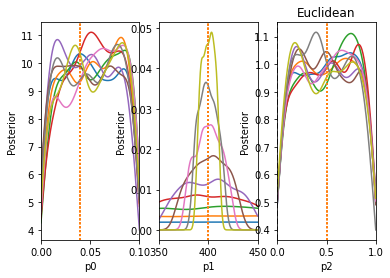

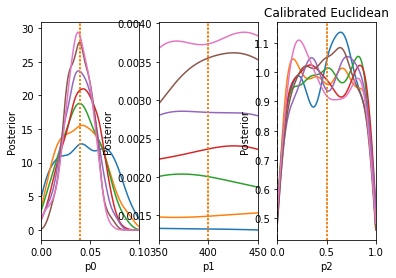

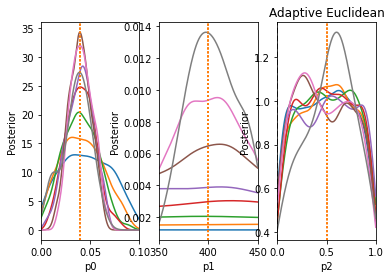

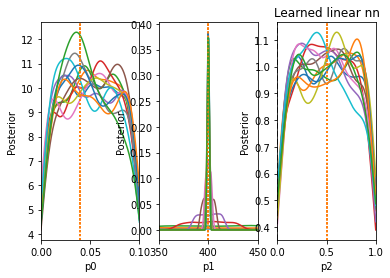

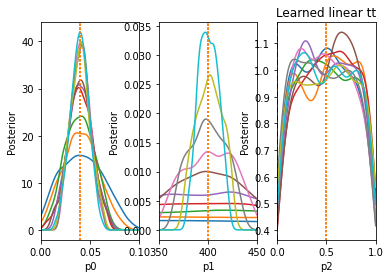

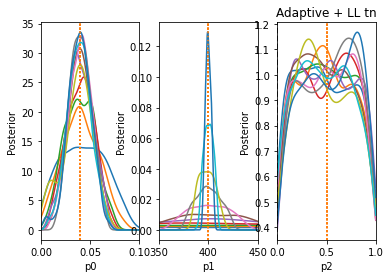

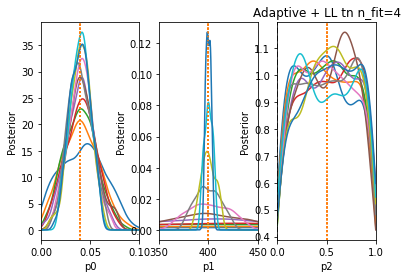

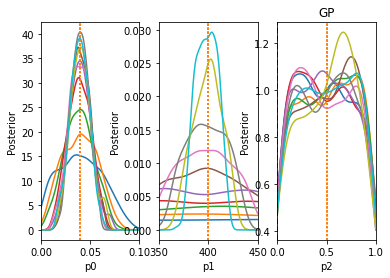

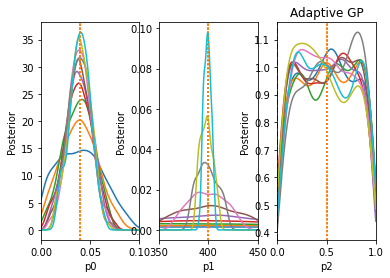

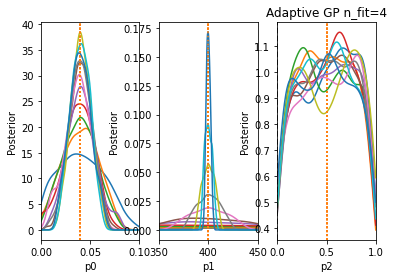

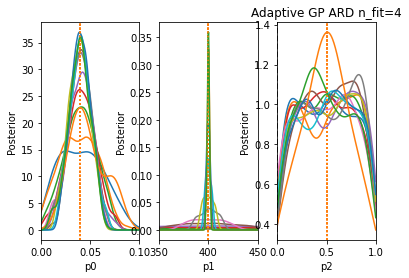

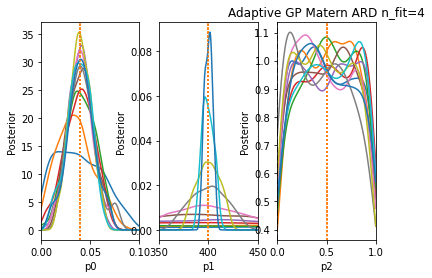

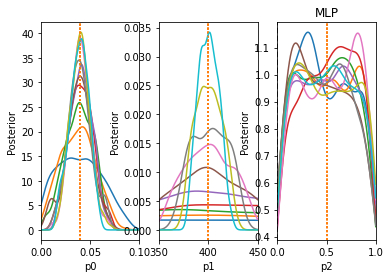

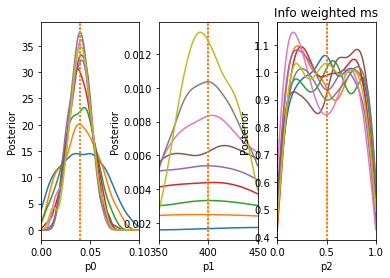

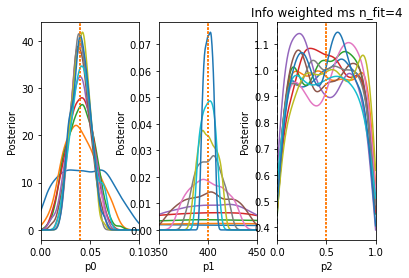

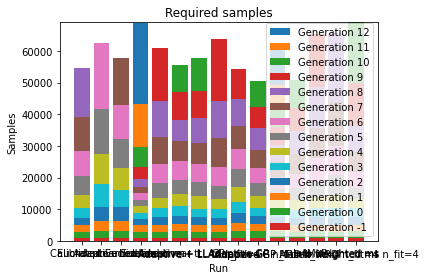

In [13]:
import matplotlib.pyplot as plt

for h, label in zip(hs, labels):
    plot_history(h, label)
pyabc.visualization.plot_sample_numbers(hs, labels)

<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

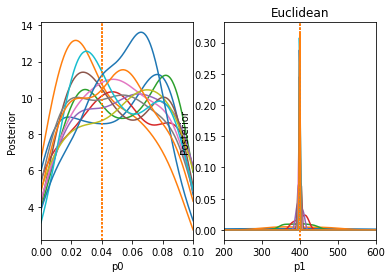

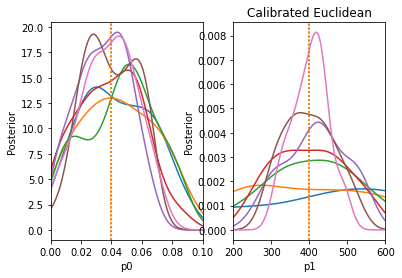

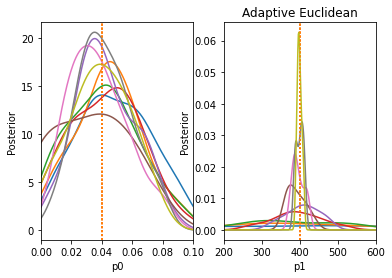

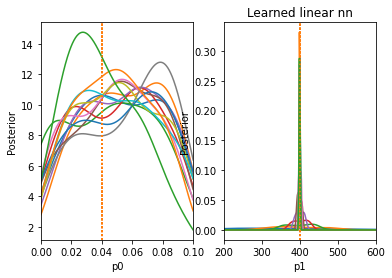

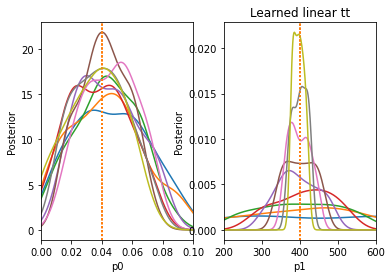

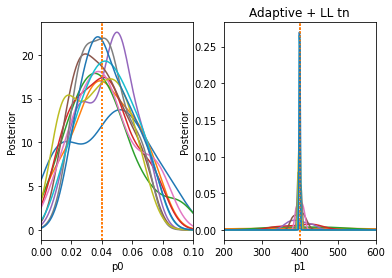

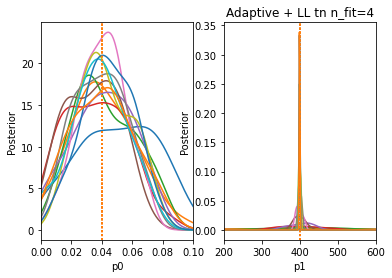

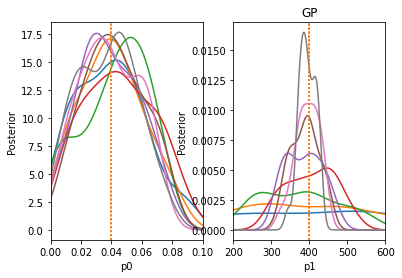

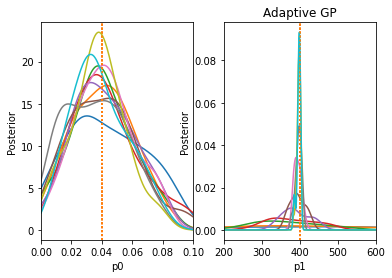

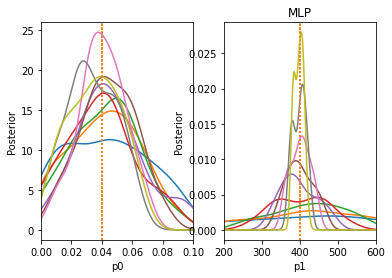

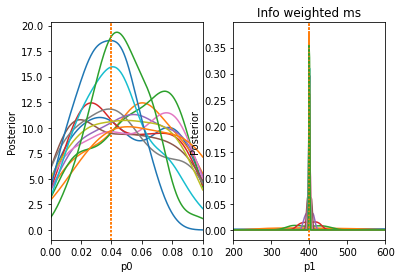

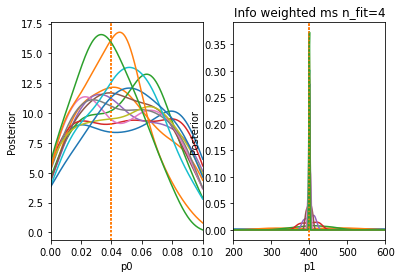

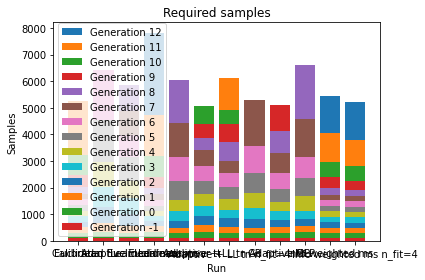

In [7]:
import matplotlib.pyplot as plt

for h, label in zip(hs, labels):
    plot_history(h, label)
pyabc.visualization.plot_sample_numbers(hs, labels)